# Project 2

## Monte Carlo analysis of a nonlinear inverse problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import seaborn as sns
import pandas as pd

((0.0, 41900.0, 1.2375848050000008e-09, 1.4433502929499998e-07), None)

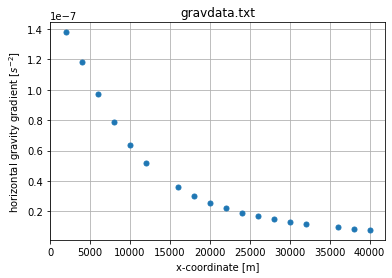

In [ ]:
data = np.loadtxt('gravdata.txt')
xcoor = data[:,0]*1e3
d_obs = data[:,1]

plt.plot(xcoor,d_obs,'.',markersize=10)
plt.xlabel('x-coordinate [m]'),plt.ylabel(r'horizontal gravity gradient [$s^{-2}$]'),plt.title('gravdata.txt')
plt.axis([0,None,None,None]),plt.grid()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# New section

In [ ]:
M = 10  # number of model parameters
N = d_obs.shape[0]

m = np.zeros(10) #first 5 are hights, last 5 are density differences

G = 6.67e-11  # gravitational constant
s = 10**(-9)

In [ ]:
def h_to_z(h):
  z = np.zeros(6)
  for i in range(len(h)+1):
    z[i] = np.sum(h[:i])
  return z

h = np.array([1,2,3,4,5])

print(h_to_z(h))
def gravfunction(model):
  model = model.copy()
  z = h_to_z(model[0:5])
  d_est = np.zeros_like(d_obs)
  for i in range(len(d_est)):
    for j in range(int(len(model)/2)):
      d_est[i] += model[j+5]*G*np.log((z[j+1]**2+xcoor[i]**2)/(z[j]**2+xcoor[i]**2))
  return d_est


[ 0.  1.  3.  6. 10. 15.]


The $\textit{a posteriori}$ probability density is
$$\sigma(\mathbf{m}) = \rho(\mathbf{m}) L(\mathbf{m}).$$
The likelihood function is
$$L(\mathbf{m}) = -K_1 \exp\left(-\frac{||\mathbf{d}_{obs}-\mathbf{g(m)}||^2}{2s^2}\right).$$

The constraints are 
$$2 \: km \leq h_i \leq 10 \: km$$
and
$$-2000 \: kg/m^3 \leq \Delta \rho_i \leq 2000 \: kg/m^3$$

The misfit is 
$$S(\mathbf{m}) = -ln(L(\mathbf{m}))$$

In [ ]:
def norm2(v):
  return np.sqrt(np.dot(v,v))
  
def S(m): # Misfit
  return norm2(d_obs-gravfunction(m))**2/(2*s**2)

Perturbation is accepted with probability

$$exp(-(S(\mathbf{m}_k^{pert})-S(\mathbf{m}_k) \:\:\: \textrm{for} \: \: S(\mathbf{m}_k^{pert})>S(\mathbf{m}_k)$$

In [ ]:
def accept(m0, m1):
    if S(m1) > S(m0):
        p = np.exp(-(S(m1)-S(m0)))
    else:
        p = 1
    return p

In [ ]:
np.random.uniform(2000,10000,5)

array([6568.34408308, 8960.87881222, 4870.30868249, 6897.1960515 ,
       7289.41996634])

## Metropolis

# New Section

In [ ]:
l = 50
def rand_m():
  
  m1 = np.random.uniform(2000,10000,5)
  m2 = np.random.uniform(-2000,2000,5)
  return(np.concatenate((m1,m2)))

m_max1 = np.ones(5)*10000
m_max2 = np.ones(5)*2000
m_max = np.concatenate((m_max1,m_max2))
m_min1 = np.ones(5)*2000
m_min2 = np.ones(5)*(-2000)
m_min = np.concatenate((m_min1,m_min2))

def rand_step(m,l):
  m=m.copy()
  i = np.random.randint(0,10)
  m_step = np.zeros_like(m)
  m_step[i] += np.random.uniform(-l,l)
  if (m + m_step)[i]< m_min[i] or (m + m_step)[i]> m_max[i]:
    m_step = np.zeros_like(m)

  return m_step
##m = rand_m()
#m_step =  rand_step(m,10)
#m_new = m + m_step

#print(m)
#print(m_step)
#print(gravfunction(m))
#print(gravfunction(m_new))
#print(S(m_new)-S(m))

In [ ]:
def metropolis(N):
  models = np.zeros((N,10))
  number = np.arange(N)
  accepted_numbers = 0
  s_values = np.zeros(N)

  m = m_min/2+m_max/2
  for i in range(N):
    m_new = m+rand_step(m,l)
    p = accept(m,m_new)
    if np.random.uniform(0,1) <= p:
      m = m_new
      accepted_numbers += 1

    models[i,:] = m
    s_values[i] = S(m)
    if i %10000 ==0:
      print(f'iteration {i} complete')
  
  return number,models,s_values,accepted_numbers


In [ ]:
number, models,s_values, accepted_numbers = metropolis(80000)

it has done 0 interations
it has done 10000 interations
it has done 20000 interations
it has done 30000 interations
it has done 40000 interations
it has done 50000 interations
it has done 60000 interations
it has done 70000 interations


In [ ]:
rate = accepted_numbers/len(number)

if 0.3 > rate or rate >0.7:
  print('--Warning!-- Extreme acceptance rate:', rate)
else:
  print('Acceptance rate:', rate)

Acceptance rate: 0.5881375


Estimated model parameters are [6243.003234   7056.07153267 2983.139442   8601.67442689 9483.75013733
   69.12203808 1277.34059959  187.73662504  -12.55932187   21.24241471]
0.5118303312775694
0.021241820973513997


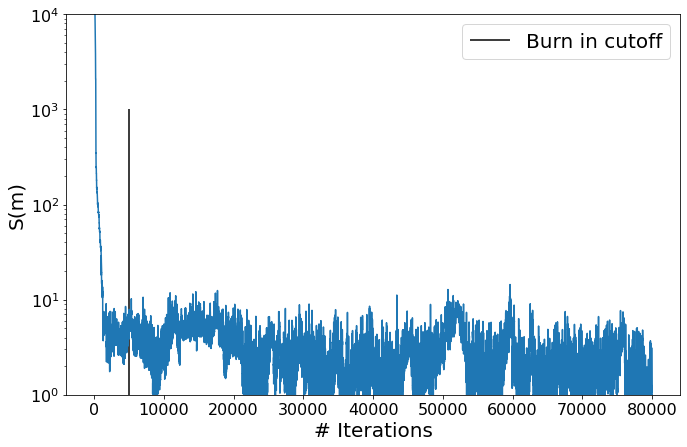

Estimated model parameters are [6243.003234   7056.07153267 2983.139442   8601.67442689 9483.75013733
   69.12203808 1277.34059959  187.73662504  -12.55932187   21.24241471]
0.5118303312775694
0.021241820973513997


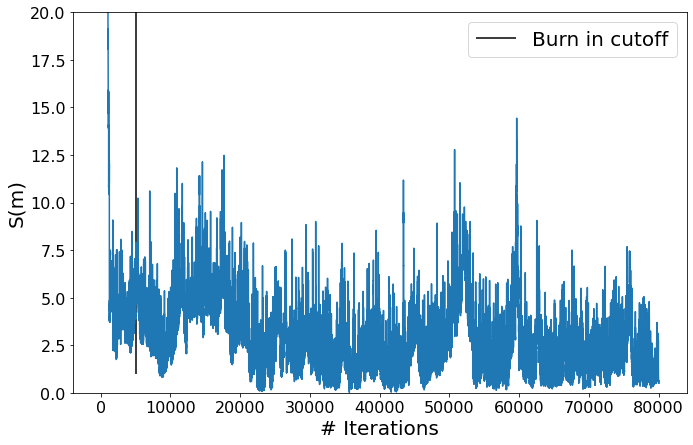

In [ ]:
plt.figure(figsize=(11,7))
plt.plot(number,s_values)
print('Estimated model parameters are', models[-1,:])
plt.yscale('log')
plt.ylim(1,10**(4))
print(S(models[-1,:]))
print(min(s_values))
burnin_time = 5000
plt.xlabel('# Iterations',fontsize=20)
plt.ylabel('S(m)',fontsize=20)
plt.vlines(burnin_time,1,10**3,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


plt.figure(figsize=(11,7))
plt.plot(number,s_values)
print('Estimated model parameters are', models[-1,:])
plt.ylim(0,20)
print(S(models[-1,:]))
print(min(s_values))
burnin_time = 5000
plt.xlabel('# Iterations',fontsize=20)
plt.ylabel('S(m)',fontsize=20)
plt.vlines(burnin_time,1,10**3,label='Burn in cutoff')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
print((gravfunction(models[-1,:])-d_obs)/s)

[ 0.74084792 -0.58348007 -0.10169124  0.17911577  0.2213788   0.17392041
  0.06961835  0.04097682  0.02542335  0.01856121  0.01688485  0.01799334
  0.02036713  0.02313538  0.02579918  0.02999173  0.03140348  0.03238354]


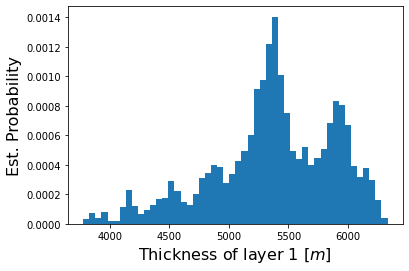

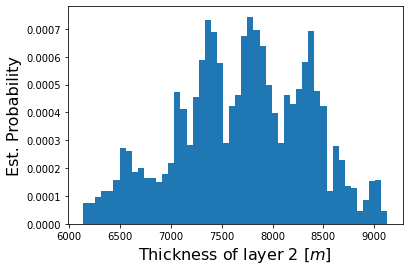

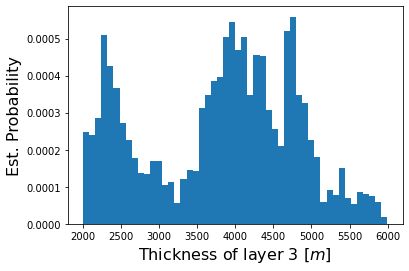

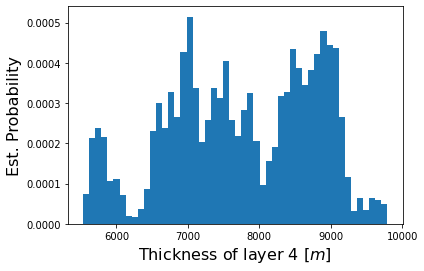

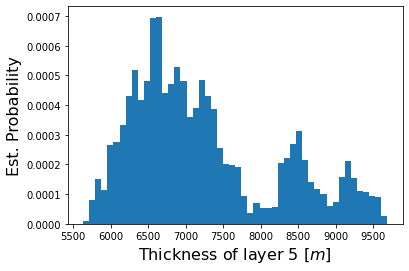

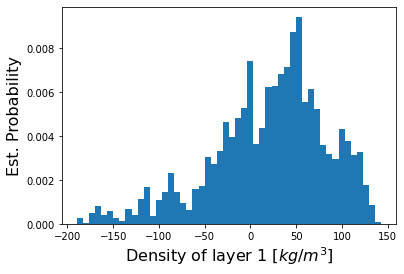

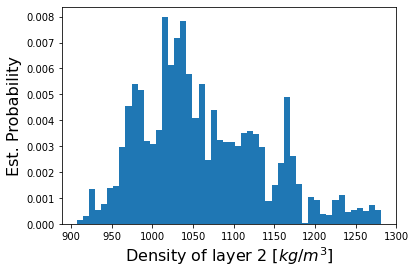

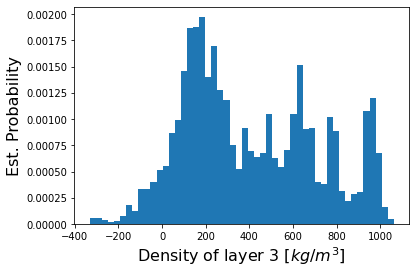

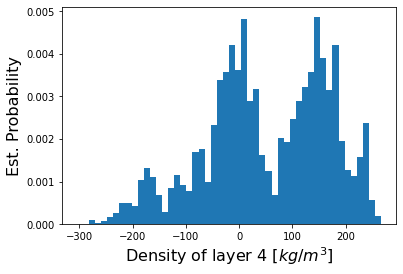

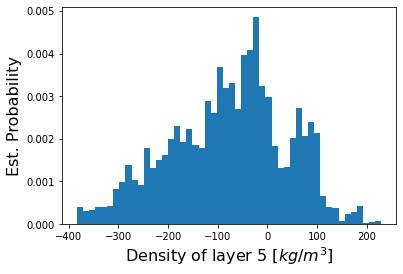

In [ ]:
for i in range(5):
  plt.figure()
  plt.hist(models[burnin_time:,i], density=True, bins=50)  # density=False would make counts
  plt.ylabel('Est. Probability',fontsize=16)
  plt.xlabel(f"Thickness of layer {i+1} [$m$]",fontsize=16);

for i in range(5):
  plt.figure()
  plt.hist(models[burnin_time:,5+i], density=True, bins=50)  # density=False would make counts
  plt.ylabel('Est. Probability',fontsize=16)
  plt.xlabel(f"Density of layer {i+1} [$kg/m^3$]",fontsize=16);

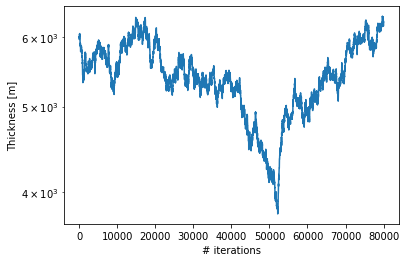

In [ ]:
plt.plot(number,models[:,0], label='Burn in cutoff')
plt.ylabel('Thickness [m]')
plt.xlabel('# iterations')
plt.yscale('log')

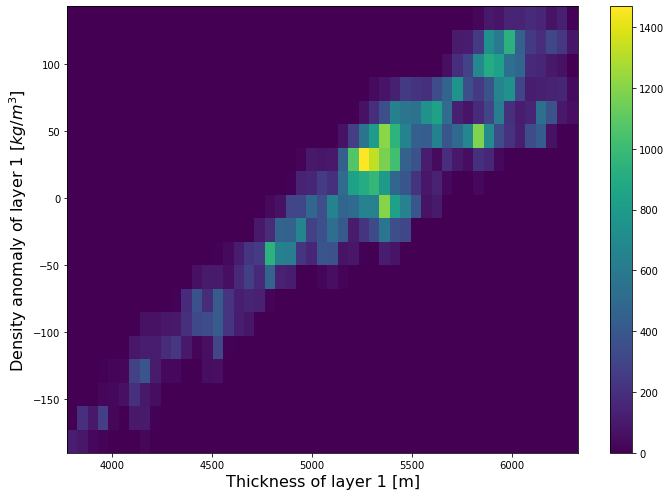

In [ ]:
 
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
  
# Creating dataset
x = models[burnin_time:,0]
y = models[burnin_time:,5]
  
# Creating bins
x_min = np.min(x)
x_max = np.max(x)
  
y_min = np.min(y)
y_max = np.max(y)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)
  
fig, ax = plt.subplots(figsize =(10, 7))
# Creating plot
plt.hist2d(x, y, bins =[x_bins, y_bins])
#h = ax.hist2d(x, y, bins =[x_bins, y_bins])

ax.set_xlabel('Thickness of layer 1 [m]',fontsize=16) 
ax.set_ylabel('Density anomaly of layer 1 $[kg/m^3]$',fontsize=16) 

#im = ax.imshow(x,y)
#fig.colorbar(h, ax=ax)
plt.colorbar()

# show plot
plt.tight_layout() 
plt.show()

In [ ]:
models.shape

(80000, 10)

In [ ]:
models_abi = models[4000:]
thick0 = models_abi[:,0]
thick1 = models_abi[:,1]
thick2 = models_abi[:,2]
thick3 = models_abi[:,3]
thick4 = models_abi[:,4]

dense5 = models_abi[:,5]
dense6 = models_abi[:,6]
dense7 = models_abi[:,7]
dense8 = models_abi[:,8]
dense9 = models_abi[:,9]

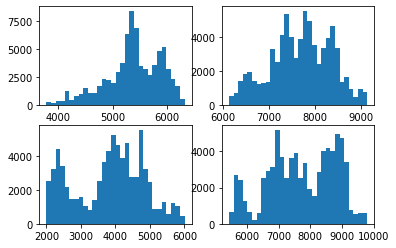

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0,0].hist(thick0, bins=30)
ax[0,1].hist(thick1, bins=30)
ax[1,0].hist(thick2, bins=30)
ax[1,1].hist(thick3, bins=30);

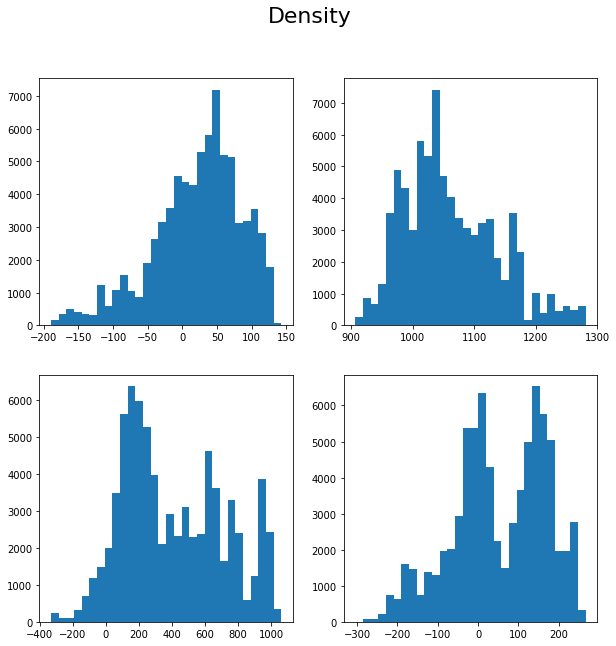

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(dense5,bins=30)
ax[0,1].hist(dense6,bins=30)
ax[1,0].hist(dense7,bins=30)
ax[1,1].hist(dense8,bins=30)
fig.suptitle('Density', fontsize=22);

In [ ]:
N_ = models_abi.shape[0]
layers = np.ones(5*N_)
layers[0:N_] = 1
layers[1*N_:2*N_] = 2
layers[2*N_:3*N_] = 3
layers[3*N_:4*N_] = 4
layers[4*N_:5*N_] = 5
thick = np.concatenate((thick0, thick1, thick2, thick3, thick4))
dense = np.concatenate((dense5, dense6, dense7, dense8, dense9))
df_all = pd.DataFrame(data = {'Thickness': thick, 'Density': dense, 'Layer': layers})
df = df_all.loc[df_all['Layer'] == 1]

In [ ]:
df['Layer'].unique()

array([1.])

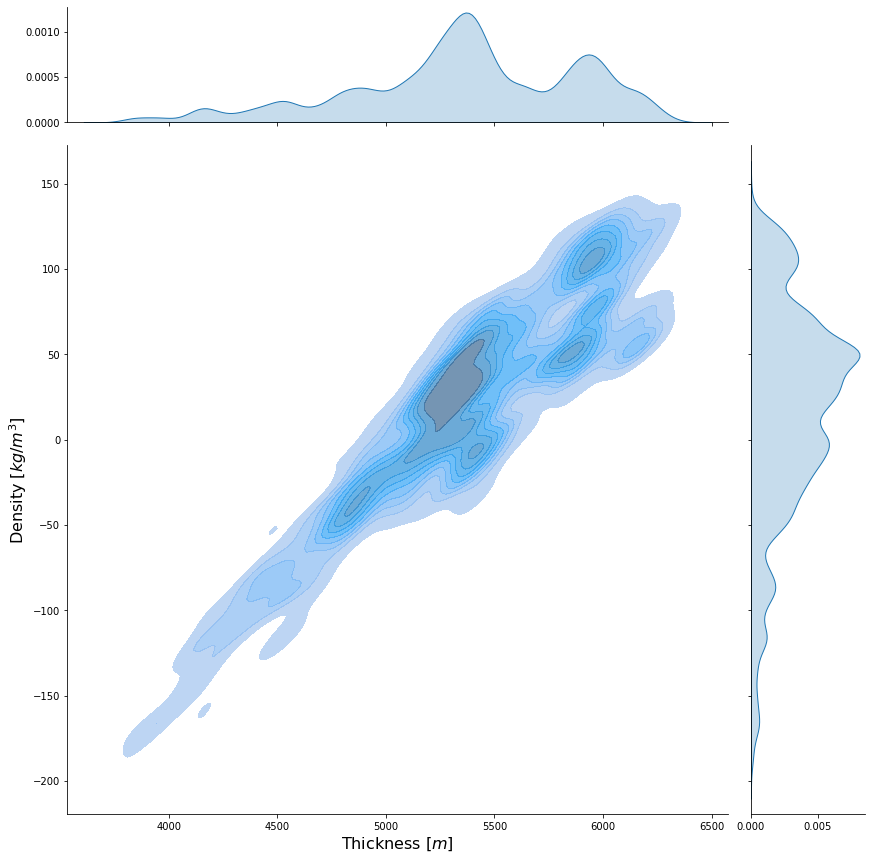

In [ ]:
snsplot = sns.jointplot(data=df[burnin_time:],
              x='Thickness',
              y='Density',
              kind='kde',
              #hue='Layer',
              fill=True, 
              joint_kws={'alpha': 0.7},
              height=12,
              #palette=cm.Set1
              marginal_ticks = True,
              #cbar=True
              );
fs = 16
#sns.set(font_scale = 2)
snsplot.ax_joint.set_xlabel(r'Thickness [$m$]', fontsize=fs)
snsplot.ax_joint.set_ylabel(r'Density [$kg/m^3$]', fontsize=fs);

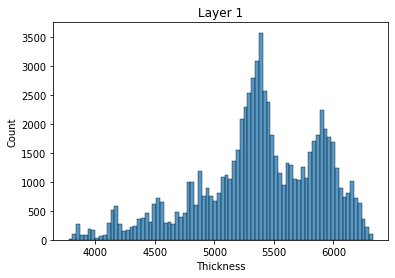

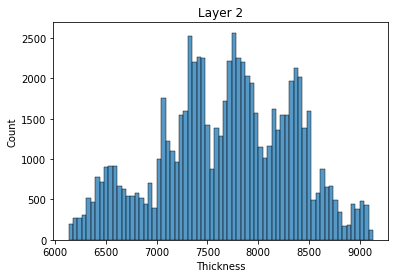

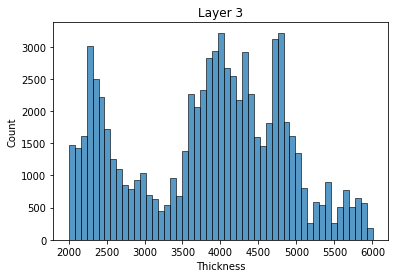

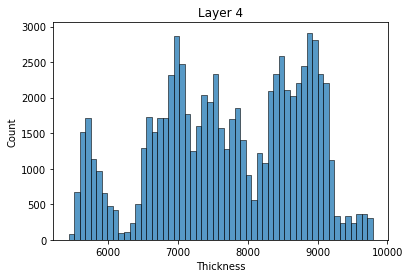

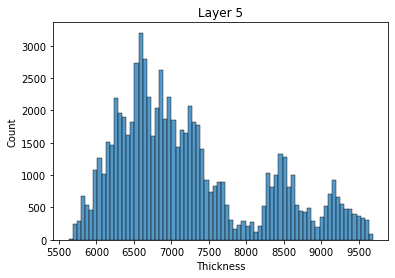

In [ ]:
for i in np.arange(1,6):
  plt.figure()
  sns.histplot(df_all.loc[df_all['Layer']==i]['Thickness'])
  plt.title(f'Layer {i}')